In [1]:
import copy
from functools import partial
from typing import *

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wandb
import wandb.apis

api = wandb.Api()

In [2]:
def load_one(run: wandb.apis.public.Run) -> Dict[str, Any]:
    if "count" in run.summary:
        task = run.config["task"]["name"]
        sparsity = copy.deepcopy(run.config["sparsity"])
        bpc = [r["bpc"] for r in run.summary["results"]]
        return dict(
            task=task,
            model=run.config["model"].split("/")[1].replace("-hf", "").lower(),
            **sparsity,
            prefill_length=run.summary["prefill_length"],
            bpc=np.mean(bpc),
            bpc_stderr=np.sqrt(np.var(bpc) / len(bpc)),
        )

def load_sweep(experiment_name: str, *single_runs: str) -> pd.DataFrame:
    return pd.DataFrame.from_dict(filter(None, (
        load_one(run)
        for run in api.runs(
            "research/sparse-attention", {"$or": [
                {"config.name": experiment_name},
                *({"display_name": n} for n in single_runs)
            ]}
        )
    )))

df = load_sweep("RMOE-72-local")
df.head()

,task,model,k,name,initial_k,prefill_length,bpc,bpc_stderr
0,wikitext_bpc,pythia-1.4b,512.0,local,16.0,1348.84,0.842227,0.013379
1,wikitext_bpc,pythia-1.4b,512.0,local,0.0,1348.84,1.321525,0.020523
2,wikitext_bpc,llama-2-7b,256.0,local,0.0,1564.99,1.032984,0.017928
3,wikitext_bpc,llama-2-7b,256.0,local,4.0,1564.99,0.892313,0.012582
4,wikitext_bpc,llama-2-7b,NaN,dense,NaN,1564.99,0.791064,0.012559


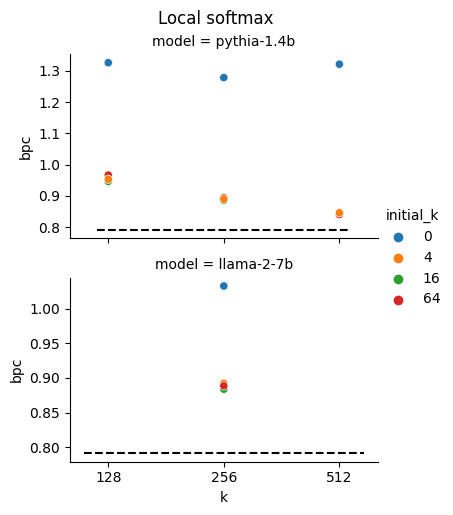

In [11]:
g = sns.relplot(data=df[df.name=="local"].pipe(lambda d: d.assign(initial_k=d.initial_k.astype("long").map(str))),
                y="bpc", x="k", hue="initial_k", hue_order=["0", "4", "16", "64"], row="model", facet_kws=dict(sharey=False),
                aspect=1.6, height=2.5)
for model, ax in g.axes_dict.items():
    ax.set_xscale("log", base=2)
    ax.hlines(df[(df.model==model)&(df.k.isna())].bpc.item(), *ax.get_xlim(), colors="k", linestyles="--")
    ax.xaxis.set_major_formatter("{x:.0f}")
plt.suptitle("Local softmax", y=1.02);